# Casys MCP Gateway - The Story

Welcome to the Casys MCP Gateway playground. This series of notebooks will teach you not just _how_
to use the gateway, but _why_ it exists and what problems it solves.

---

## Learning Objectives

After completing this notebook series, you will:

- [ ] Understand the MCP context explosion problem
- [ ] Know how to reduce context usage from 30-50% to <5%
- [ ] See how Claude composes code that PML executes securely
- [ ] Understand how capabilities emerge from successful executions
- [ ] Learn to reuse proven code patterns without regeneration

## The Problem: MCP Doesn't Scale

The Model Context Protocol (MCP) is amazing. It lets AI agents like Claude connect to tools -
GitHub, databases, file systems, browsers, and more.

But there's a problem. A big one.

### The "Invisible Tax"

Every MCP server sends its **entire tool catalog** to the LLM at the start of each conversation.

```
You have 8 MCP servers installed:
- GitHub (15 tools)      ~12,000 tokens
- Filesystem (8 tools)    ~6,000 tokens  
- Database (12 tools)     ~9,000 tokens
- Playwright (20 tools)  ~18,000 tokens
- Slack (10 tools)        ~8,000 tokens
- Notion (14 tools)      ~11,000 tokens
- Jira (16 tools)        ~13,000 tokens
- Custom API (5 tools)    ~4,000 tokens
─────────────────────────────────────────
TOTAL: ~81,000 tokens (just for tool schemas!)
```

With a 200K token context window, **40% is already consumed** before you even say "Hello".

### The Latency Problem

Now suppose Claude needs to:

1. Read a config file
2. Parse it as JSON
3. Fetch related GitHub issues
4. Search Slack for discussions
5. Create a Jira ticket

Each tool call is **sequential**. 5 tools × 1 second each = **5 seconds of waiting**.

But steps 3 and 4 don't depend on each other. They could run in parallel!

## The Solution: Casys MCP Gateway

Casys MCP Gateway enables a new paradigm: **Claude composes code, PML executes it**.

### The Paradigm Shift

Instead of orchestrating individual MCP tool calls:

1. **Claude composes** TypeScript code that uses MCP tools
2. **PML executes** the code in a secure Worker sandbox
3. **The sandbox calls** MCP tools via RPC Bridge (all calls traced)
4. **The system learns** from each successful execution (capabilities emerge)
5. **Proven code is reused** without Claude having to regenerate it

### How It Works

#### 1. Context Optimization (30-50% → <5%)

- **Indexes** all tools using vector embeddings (semantic search)
- **Loads on-demand** only the relevant tools for each query
- **Result**: 100 tools available, but only 3-5 loaded per request

#### 2. Worker RPC Bridge (Safe execution with MCP access)

- **Claude composes** TypeScript code with `mcp.server.tool()` calls
- **Worker executes** in isolated Deno sandbox (permissions: none)
- **RPC Bridge** routes tool calls to real MCP servers (all traced natively)

#### 3. Capability Learning (Gets smarter over time)

- **Eager learning**: Store capability on first successful execution
- **Search capabilities**: Find matching code by intent similarity
- **Suggestion Engine**: Proactive recommendations based on context

#### 4. Emergent Reuse (Skip regeneration)

- **Match intent** → retrieve cached capability code
- **Execute directly** → skip Claude code generation (~2-5s saved)
- **Inline injection** → capabilities available as functions in Worker

## The Journey

This playground takes you through Casys MCP Gateway step by step:

| Notebook                    | What You'll Learn                                        |
| --------------------------- | -------------------------------------------------------- |
| **01-the-problem**          | See the MCP context explosion and latency issues live    |
| **02-context-optimization** | Reduce context usage with vector search                  |
| **03-dag-execution**        | Parallelize workflows with DAG                           |
| **04-sandbox-security**     | Execute code with MCP tool access via Worker RPC Bridge  |
| **05-capability-learning**  | See how capabilities emerge from code execution          |
| **06-emergent-reuse**       | Reuse proven code without regeneration                   |

Each notebook:

- Starts with **why** (the problem it solves)
- Shows **how** (with runnable examples)
- Ends with a **checkpoint** to verify understanding

> **Note:** Previous notebooks (07-09) have been archived. The sequence above covers all core concepts.

## Quick Start

Before diving in, let's verify your environment is ready:

In [1]:
// Environment Check - Full verification
import { ensurePlaygroundReady } from "../lib/init.ts";

console.log("🔍 Checking playground environment...\n");

// 1. Check Deno version (2.2+ recommended)
const denoVersion = Deno.version.deno;
const [major, minor] = denoVersion.split(".").map(Number);
const denoOk = major >= 2 && (major > 2 || minor >= 2);
console.log(`Deno version: ${denoVersion} ${denoOk ? "✅" : "⚠️ (2.2+ recommended)"}`);
console.log(`TypeScript: ${Deno.version.typescript}`);
console.log(`V8: ${Deno.version.v8}\n`);

// 2. Check API key availability
const hasOpenAI = !!Deno.env.get("OPENAI_API_KEY");
const hasAnthropic = !!Deno.env.get("ANTHROPIC_API_KEY");
const hasGoogle = !!Deno.env.get("GOOGLE_API_KEY");
const hasApiKey = hasOpenAI || hasAnthropic || hasGoogle;

console.log("API Keys:");
console.log(`  OPENAI_API_KEY:    ${hasOpenAI ? "✅ Set" : "❌ Not set"}`);
console.log(`  ANTHROPIC_API_KEY: ${hasAnthropic ? "✅ Set" : "❌ Not set"}`);
console.log(`  GOOGLE_API_KEY:    ${hasGoogle ? "✅ Set" : "❌ Not set"}`);
console.log(`  Status: ${hasApiKey ? "✅ At least one LLM API key available" : "⚠️ No API key found (set one to use LLM features)"}\n`);

// 3. Check gateway imports
try {
  const { DenoSandboxExecutor } = await import("../../src/sandbox/executor.ts");
  console.log("Gateway modules: ✅ Loaded successfully\n");
} catch (e) {
  console.error("Gateway modules: ❌ Error loading\n", e.message);
}

// 4. Full environment check with ensurePlaygroundReady
console.log("Running full environment check...\n");
const status = await ensurePlaygroundReady({ verbose: true });

console.log("\n" + "─".repeat(50));
console.log("📊 Environment Status:");
console.log(`   Initialized: ${status.initialized ? "✅ Yes" : "ℹ️ Already ready"}`);
console.log(`   MCP Servers: ${status.mcpServers.length > 0 ? status.mcpServers.join(", ") : "(gateway not running - OK for intro)"}`);
console.log(`   Workflows:   ${status.workflowsLoaded}`);
console.log(`   Time:        ${status.elapsedMs}ms`);
if (status.error) {
  console.log(`   ⚠️ Note: ${status.error}`);
}
console.log("─".repeat(50));
console.log("\n🚀 You're ready to start the journey!");

🔍 Checking playground environment...

Deno version: 2.5.6 ✅
TypeScript: 5.9.2
V8: 14.0.365.5-rusty

API Keys:
  OPENAI_API_KEY:    ✅ Set
  ANTHROPIC_API_KEY: ❌ Not set
  GOOGLE_API_KEY:    ❌ Not set
  Status: ✅ At least one LLM API key available

WARN EventBus: BroadcastChannel not available, using local-only mode
Gateway modules: ✅ Loaded successfully

Running full environment check...

🔍 Checking playground initialization status...
   DB path: .pml-dev.db
   Gateway: http://localhost:3003
⚙️  Running full initialization...
   → Checking MCP gateway...
   ✗ Gateway not available
   → Loading workflow templates...
   ✗ Failed to load workflow templates: No such file or directory (os error 2): readfile './config/workflow-templates.yaml'
   → Verifying database...
   ⚠ Database empty or not initialized
✓ Initialization complete (5ms)
⚠ Partial failure: MCP gateway not available; Workflow templates: No such file or directory (os error 2): readfile './config/workflow-templates.yaml'

─────

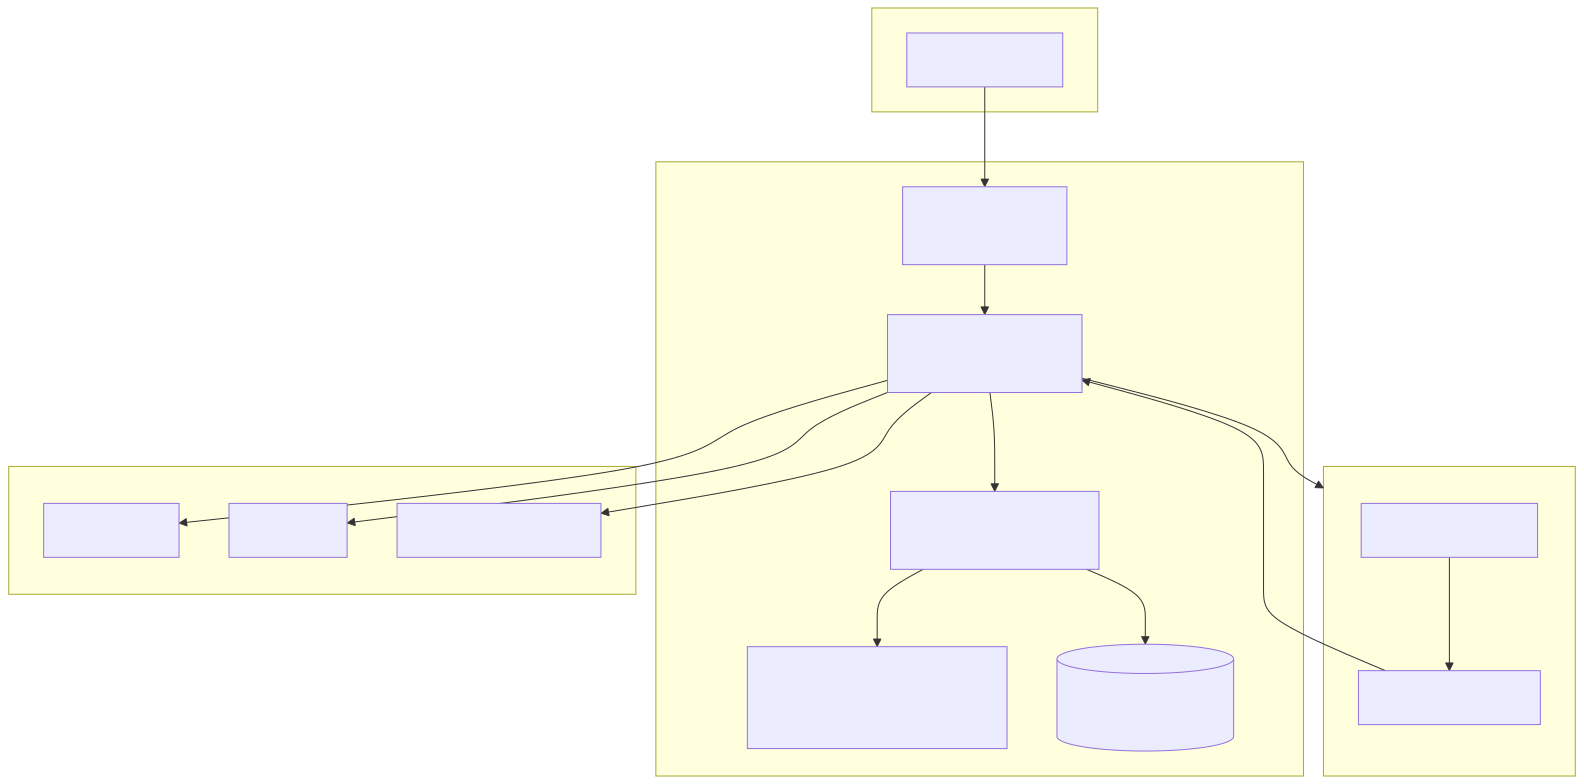

In [2]:
// Architecture Overview - Mermaid Diagram
import { displayMermaid } from "../lib/viz.ts";

await displayMermaid(`
graph TB
    subgraph Client["Claude Code (Client)"]
        A[User Request]
    end

    subgraph Gateway["Casys MCP Gateway"]
        VS[Vector Search<br/>Tool Discovery]
        WB[Worker RPC Bridge<br/>Code Execution]
        CE[Capability Engine<br/>Learning & Matching]
        SE[Suggestion Engine<br/>Proactive Recommendations]
        DB[(PGlite DB<br/>Capabilities + Patterns)]
    end

    subgraph Worker["Deno Worker (Sandbox)"]
        CODE[TypeScript Code]
        PROXY[MCP Tool Proxies]
    end

    subgraph Servers["MCP Servers"]
        FS[Filesystem]
        MEM[Memory]
        ST[Sequential Thinking]
    end

    A --> VS
    VS --> WB
    WB --> Worker
    CODE --> PROXY
    PROXY -->|RPC| WB
    WB -->|tool calls| FS & MEM & ST
    WB --> CE
    CE --> DB
    CE --> SE
`);

## Ready?

Let's see the problem in action.

**Next:** [01-the-problem.ipynb](./01-the-problem.ipynb) - Watch context explode and latency
accumulate